In [30]:
%run /Users/denis/Documents/Projects/scripts/init.ipy
os.chdir(os.getcwd().replace('/pipeline/notebooks', ''));

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### 1. Get Median AUC

In [80]:
# Get infiles
infiles = glob.glob('./s4-merged_auc.dir/*')

# Initialize results
results = []

# Loop through infiles
for infile in infiles:
    
    # Get median
    dataframe = pd.read_table(infile).dropna().groupby(['library', 'normalization']).median().reset_index()[['auc', 'library', 'normalization']]
    
    # Add prediction
    dataframe['prediction'] = os.path.basename(infile)[:-len('.txt')]
    
    # Append
    results.append(dataframe)#median_dataframe = pd.concat([median_dataframe, dataframe])
    
# Concatenate
median_dataframe = pd.concat(results).pivot_table(index=['library', 'normalization'], columns='prediction', values='auc').reset_index()
median_dataframe.head()

prediction               library           normalization  gene_auc  \
0           ARCHS4_Kinases_Coexp         autorif_overlap  0.764251   
1           ARCHS4_Kinases_Coexp  autorif_overlap_zscore  0.768668   
2           ARCHS4_Kinases_Coexp             correlation  0.961872   
3           ARCHS4_Kinases_Coexp         correlation_abs  0.881288   
4           ARCHS4_Kinases_Coexp          correlation_v2  0.971260   

prediction  library_auc  
0              0.698369  
1              0.718020  
2              0.962151  
3              0.923338  
4              0.974770

In [32]:
# ### Get fraction predicted
# fraction_dataframe = (pd.read_table(infile).dropna().groupby(['library', 'normalization']).size()/pd.read_table(infile).groupby(['library', 'normalization']).size()).rename('fraction_predicted').to_frame().reset_index()
# fraction_dataframe.head()

library           normalization  fraction_predicted
0  ARCHS4_Kinases_Coexp         autorif_overlap            0.225780
1  ARCHS4_Kinases_Coexp  autorif_overlap_zscore            0.225780
2  ARCHS4_Kinases_Coexp             correlation            0.218090
3  ARCHS4_Kinases_Coexp         correlation_abs            0.837541
4  ARCHS4_Kinases_Coexp          correlation_v2            0.176821

### 2. Merge

In [79]:
plot_dataframe.Similarity.unique()

array(['AutoRIF', 'ARCHS4 Coexpression', 'GeneRIF', 'Random',
       'Enrichr Co-occurrence'], dtype=object)

In [87]:
plot_dataframe = median_dataframe.copy()
plot_dataframe = plot_dataframe.query("normalization in ['autorif_overlap_zscore', 'correlation', 'generif_overlap_zscore', 'random', 'zscore', 'zscore_subset']").replace('correlation', 'ARCHS4 Coexpression').replace('generif_overlap_zscore', 'GeneRIF').replace('autorif_overlap_zscore', 'AutoRIF').replace('zscore_subset', 'Enrichr Co-occurrence (Subset)').replace('zscore', 'Enrichr Co-occurrence').replace('random', 'Random').rename(columns={'normalization': 'Similarity'})
plot_dataframe['diff'] = plot_dataframe['gene_auc']-plot_dataframe['library_auc']
plot_dataframe.head()

prediction               library             Similarity  gene_auc  \
1           ARCHS4_Kinases_Coexp                AutoRIF  0.768668   
2           ARCHS4_Kinases_Coexp    ARCHS4 Coexpression  0.961872   
7           ARCHS4_Kinases_Coexp                GeneRIF  0.606350   
8           ARCHS4_Kinases_Coexp                 Random  0.498968   
10          ARCHS4_Kinases_Coexp  Enrichr Co-occurrence  0.915919   

prediction  library_auc      diff  
1              0.718020  0.050648  
2              0.962151 -0.000279  
7              0.609470 -0.003120  
8              0.502784 -0.003816  
10             0.943101 -0.027181

### 3. Plot

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



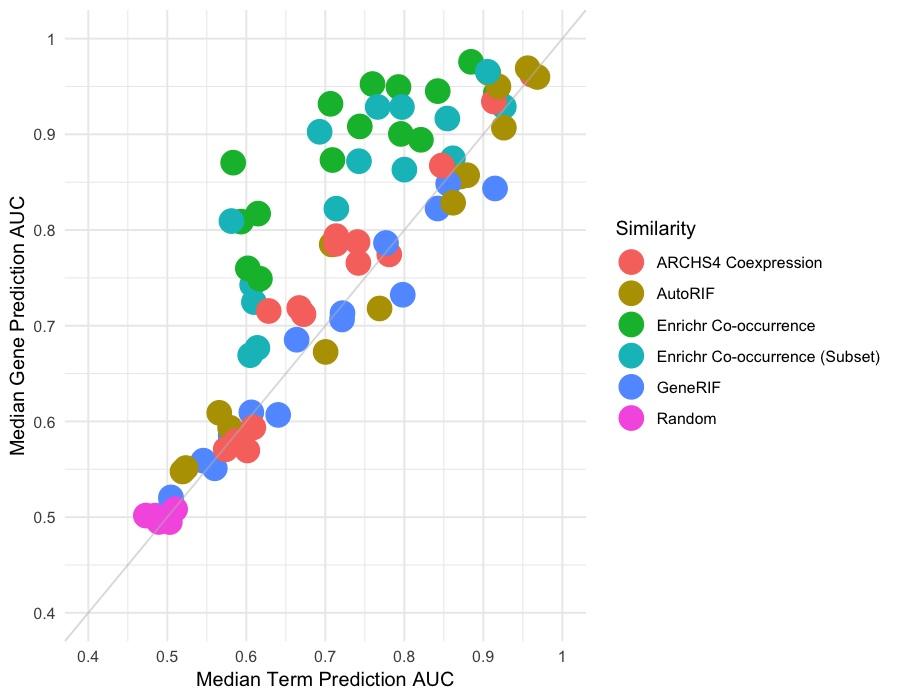

In [88]:
%%R -i plot_dataframe -h 700 -w 900 -r 130
ticks <- seq(0.4, 1, 0.1)
ggplot(plot_dataframe, aes(x=gene_auc, y=library_auc, color=Similarity)) +
geom_point(size=6) +
geom_abline(intercept=0, slope=1, alpha=0.5, color='grey') +
# facet_wrap(~library, ncol=5) +
#scale_fill_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_color_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_x_log10() +
#scale_y_log10() +
scale_x_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks) +
scale_y_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks) +
#ggtitle('') +
xlab('Median Term Prediction AUC') +
ylab('Median Gene Prediction AUC') +
theme_minimal()

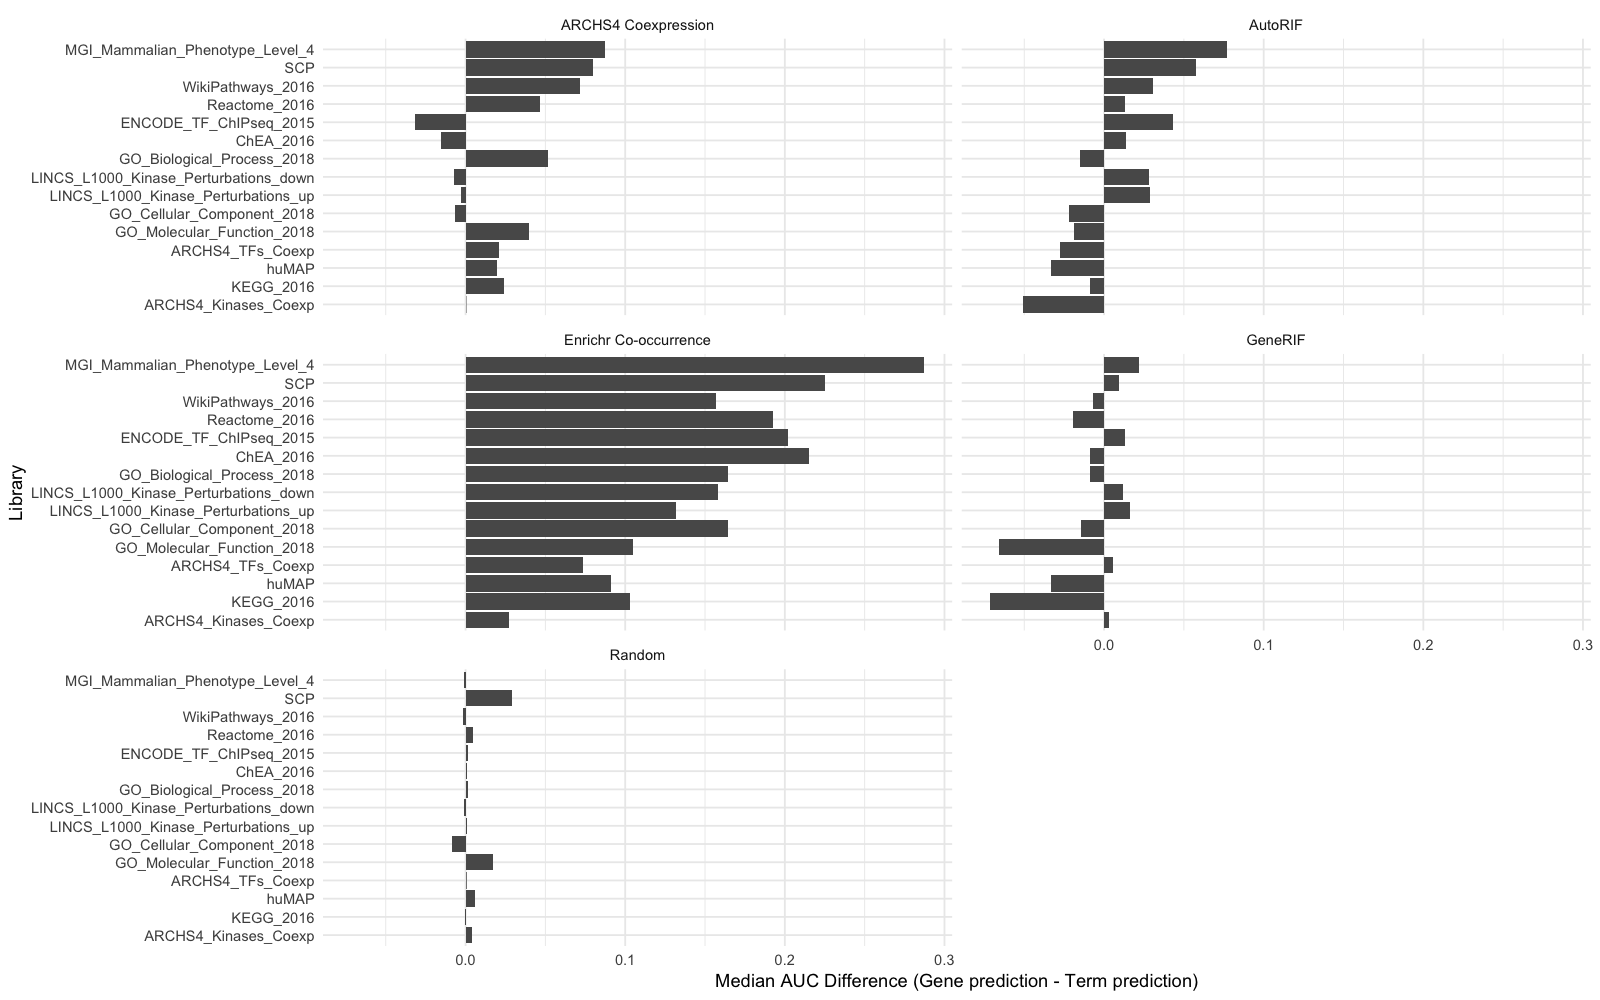

In [48]:
%%R -i plot_dataframe -h 1000 -w 1600 -r 120
#ticks <- seq()
ggplot(plot_dataframe, aes(x=reorder(library, (-diff)), y=-diff)) +
geom_bar(stat='identity') +
facet_wrap(~Similarity, ncol=2) +
coord_flip() +
#scale_fill_manual(values=c('', '')) +
#scale_fill_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_color_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_x_log10() +
#scale_y_log10() +
#scale_x_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks, trans='log10') +
#scale_y_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks, trans='log10') +
#ggtitle('') +
ylab('Median AUC Difference (Gene prediction - Term prediction)') +
xlab('Library') +
#guides(fill=FALSE) +
theme_minimal()

In [71]:
difference_dataframe = -plot_dataframe.pivot_table(index='library', columns='Similarity', values='diff')
difference_dataframe.head()

Similarity                  ARCHS4 Coexpression   AutoRIF  \
library                                                     
ARCHS4_Kinases_Coexp                   0.000279 -0.050648   
ARCHS4_TFs_Coexp                       0.020935 -0.027739   
ChEA_2016                             -0.015158  0.013880   
ENCODE_TF_ChIPseq_2015                -0.031652  0.043255   
GO_Biological_Process_2018             0.051531 -0.015181   

Similarity                  Enrichr Co-occurrence   GeneRIF    Random  
library                                                                
ARCHS4_Kinases_Coexp                     0.027181  0.003120  0.003816  
ARCHS4_TFs_Coexp                         0.073251  0.005293  0.000474  
ChEA_2016                                0.215425 -0.009051  0.001158  
ENCODE_TF_ChIPseq_2015                   0.202187  0.013407  0.001792  
GO_Biological_Process_2018               0.164094 -0.008625  0.001706

In [72]:
%%R
library(RColorBrewer)

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



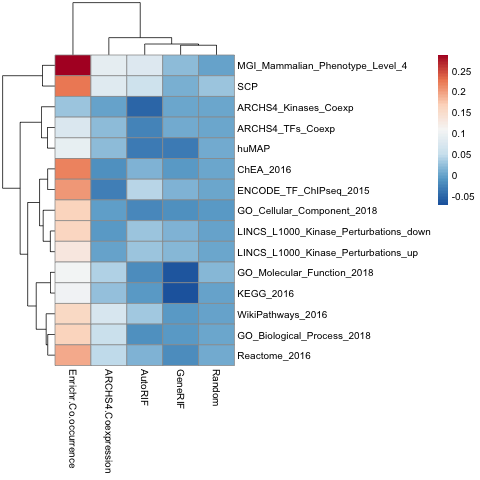

In [73]:
%%R -i difference_dataframe
pheatmap::pheatmap(difference_dataframe,
                   color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdBu")))(100))

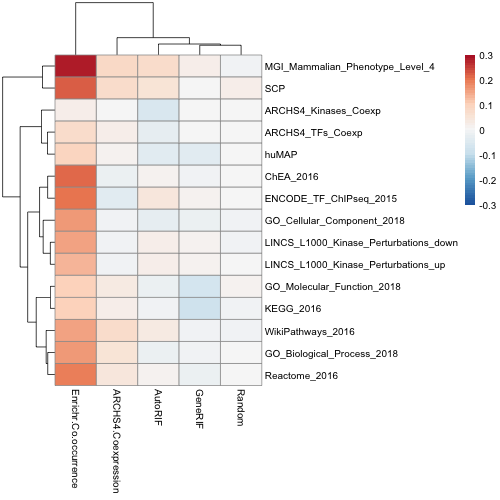

In [74]:
%%R -i difference_dataframe -h 500 -w 500
lim <- 0.3
breaks <- seq(-lim, lim, by=0.01)
pheatmap::pheatmap(difference_dataframe,
                   color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdBu")))(length(breaks)),
                   breaks=breaks)

### Other Stuff

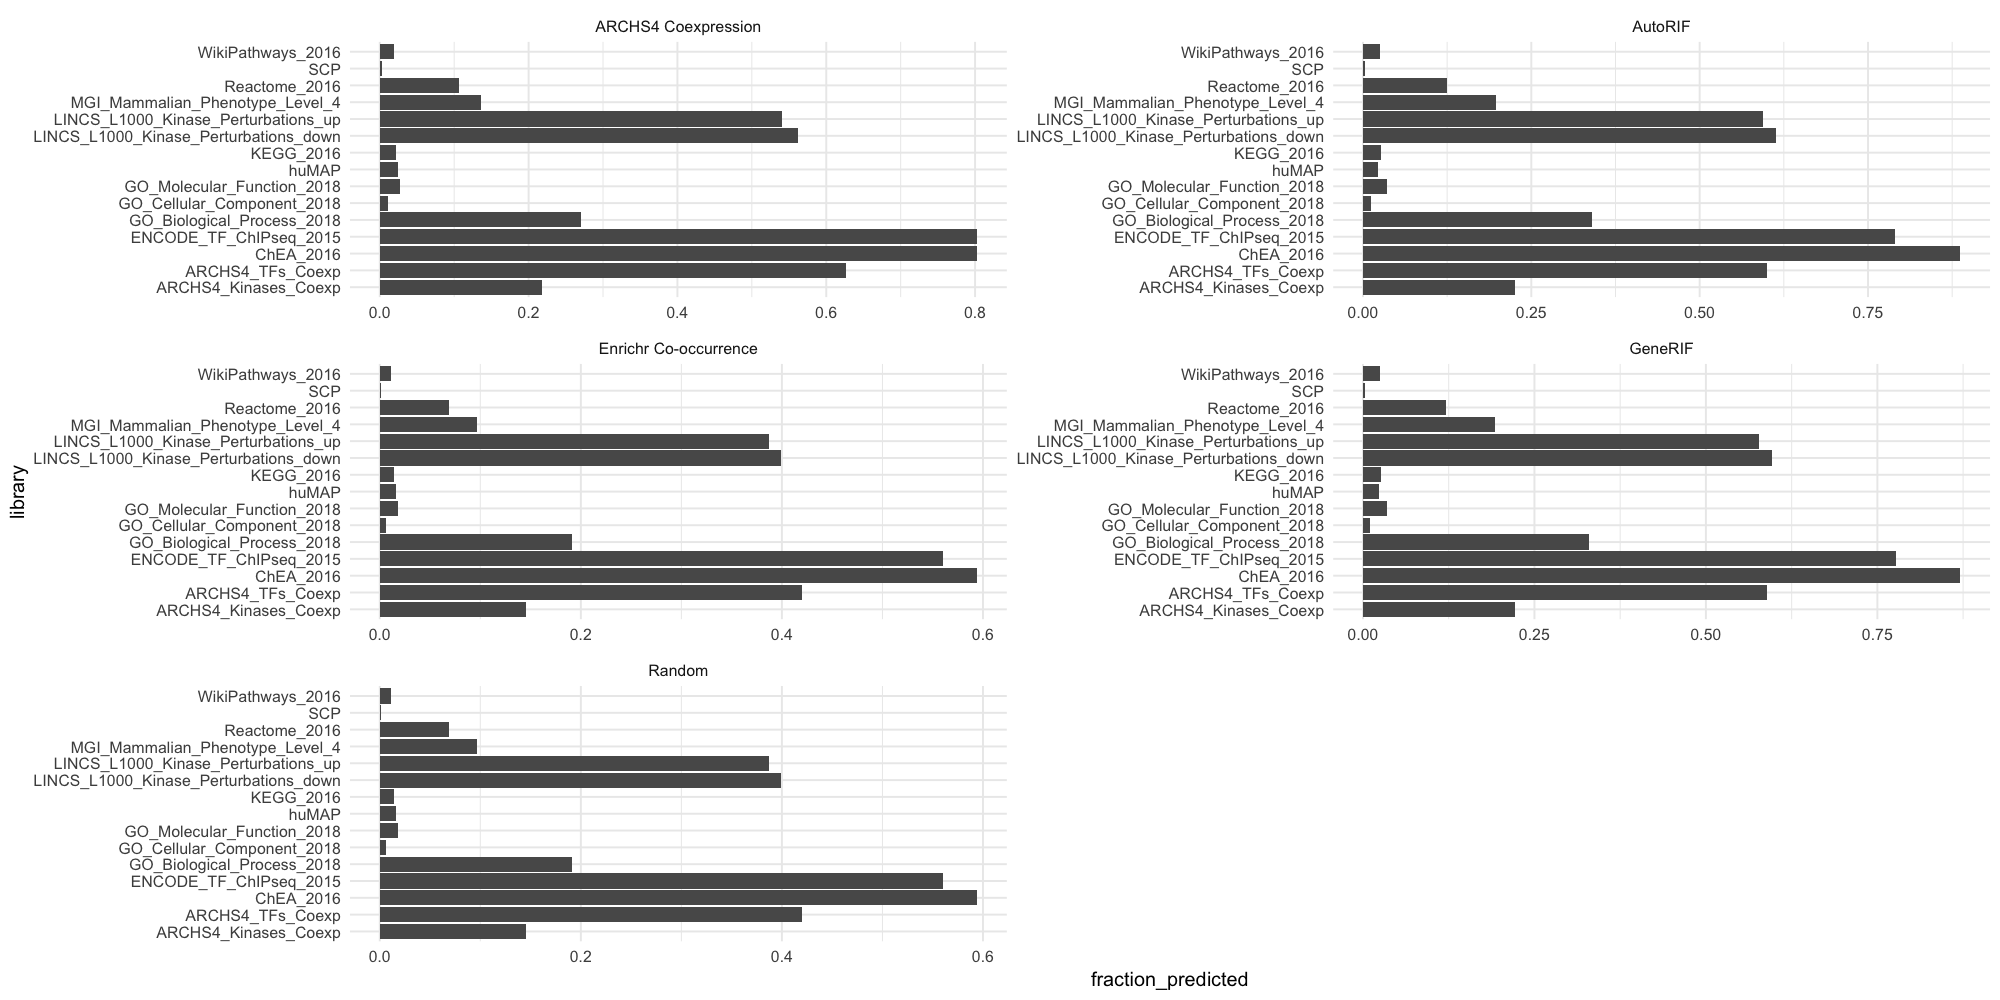

In [29]:
%%R -i plot_dataframe -h 1000 -w 2000 -r 130
#ticks <- seq()
ggplot(plot_dataframe, aes(x=library, y=fraction_predicted)) +
geom_bar(stat='identity') +
facet_wrap(~Similarity, ncol=2, scales='free') +
coord_flip() +
#scale_fill_manual(values=c('', '')) +
#scale_fill_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_color_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_x_log10() +
#scale_y_log10() +
#scale_x_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks, trans='log10') +
#scale_y_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks, trans='log10') +
#ggtitle('') +
#xlab('') +
#ylab('') +
#guides(fill=FALSE) +
theme_minimal()

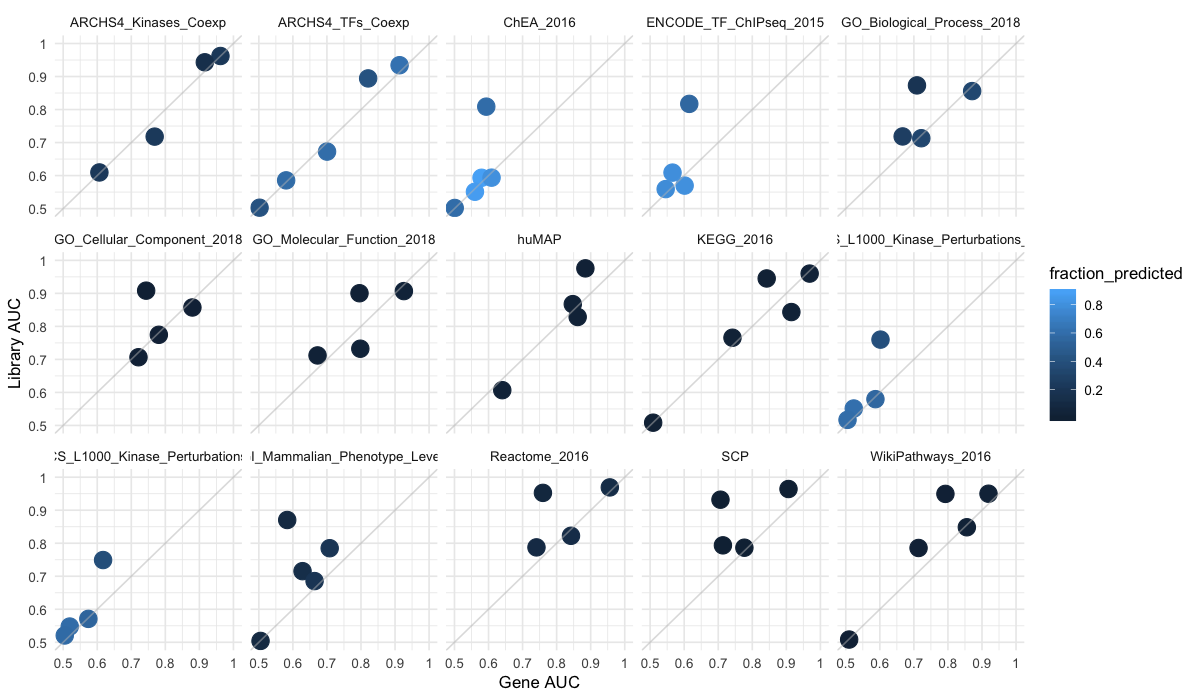

In [10]:
%%R -i plot_dataframe -h 700 -w 1200 -r 110
ticks <- seq(0.5, 1, 0.1)
ggplot(plot_dataframe, aes(x=gene_auc, y=library_auc, color=fraction_predicted)) +
geom_point(size=5) +
geom_abline(intercept=0, slope=1, alpha=0.5, color='grey') +
facet_wrap(~library, ncol=5) +
scale_x_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks) +
scale_y_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks) +
xlab('Gene AUC') +
ylab('Library AUC') +
theme_minimal()

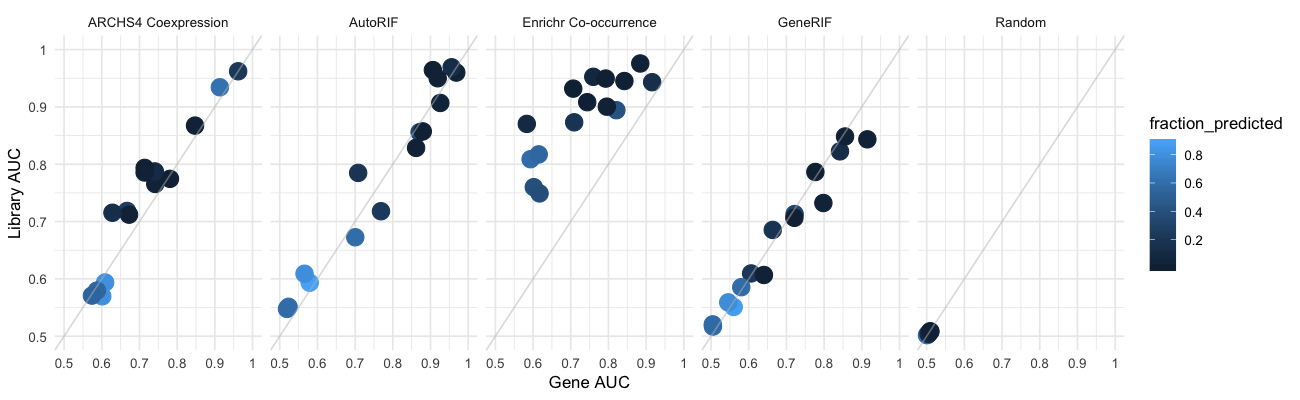

In [11]:
%%R -i plot_dataframe -h 400 -w 1300 -r 110
ticks <- seq(0.5, 1, 0.1)
ggplot(plot_dataframe, aes(x=gene_auc, y=library_auc, color=fraction_predicted)) +
geom_point(size=5) +
geom_abline(intercept=0, slope=1, alpha=0.5, color='grey') +
facet_wrap(~Similarity, ncol=5) +
scale_x_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks) +
scale_y_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks) +
xlab('Gene AUC') +
ylab('Library AUC') +
theme_minimal()

In [105]:
fraction_dataframe.head()

library           normalization  fraction_predicted
0  ARCHS4_Kinases_Coexp         autorif_overlap            0.800559
1  ARCHS4_Kinases_Coexp  autorif_overlap_zscore            0.800559
2  ARCHS4_Kinases_Coexp             correlation            0.837541
3  ARCHS4_Kinases_Coexp         correlation_abs            0.837541
4  ARCHS4_Kinases_Coexp                fraction            0.579854

In [110]:
plot_dataframe

library             Similarity  gene_auc  \
1                   ARCHS4_Kinases_Coexp                AutoRIF  0.707656   
2                   ARCHS4_Kinases_Coexp    ARCHS4 Coexpression  0.928600   
6                   ARCHS4_Kinases_Coexp                GeneRIF  0.577263   
7                   ARCHS4_Kinases_Coexp                 Random  0.501008   
9                   ARCHS4_Kinases_Coexp  Enrichr Co-occurrence  0.788226   
12                      ARCHS4_TFs_Coexp                AutoRIF  0.664822   
13                      ARCHS4_TFs_Coexp    ARCHS4 Coexpression  0.871708   
17                      ARCHS4_TFs_Coexp                GeneRIF  0.568093   
18                      ARCHS4_TFs_Coexp                 Random  0.502220   
20                      ARCHS4_TFs_Coexp  Enrichr Co-occurrence  0.736314   
23                             ChEA_2016                AutoRIF  0.580630   
24                             ChEA_2016    ARCHS4 Coexpression  0.610047   
28                             ChEA_2016                GeneRIF  0.560171   
29                             ChEA_2016                 Random  0.500778   
31                             ChEA_2016  Enrichr Co-occurrence  0.593761   
33                ENCODE_TF_ChIPseq_2015                AutoRIF  0.572429   
34                ENCODE_TF_ChIPseq_2015    ARCHS4 Coexpression  0.604845   
35                ENCODE_TF_ChIPseq_2015                GeneRIF  0.549307   
36                ENCODE_TF_ChIPseq_2015                 Random  0.499502   
37                ENCODE_TF_ChIPseq_2015  Enrichr Co-occurrence  0.628687   
39            GO_Biological_Process_2018                AutoRIF  0.894596   
40            GO_Biological_Process_2018    ARCHS4 Coexpression  0.686648   
44            GO_Biological_Process_2018                GeneRIF  0.707094   
45            GO_Biological_Process_2018                 Random  0.498804   
47            GO_Biological_Process_2018  Enrichr Co-occurrence  0.696425   
50            GO_Cellular_Component_2018                AutoRIF  0.930682   
51            GO_Cellular_Component_2018    ARCHS4 Coexpression  0.705806   
55            GO_Cellular_Component_2018                GeneRIF  0.792520   
56            GO_Cellular_Component_2018                 Random  0.496583   
58            GO_Cellular_Component_2018  Enrichr Co-occurrence  0.756264   
..                                   ...                    ...       ...   
87   LINCS_L1000_Kinase_Perturbations_up                AutoRIF  0.519446   
88   LINCS_L1000_Kinase_Perturbations_up    ARCHS4 Coexpression  0.575284   
89   LINCS_L1000_Kinase_Perturbations_up                GeneRIF  0.503799   
90   LINCS_L1000_Kinase_Perturbations_up                 Random  0.499467   
91   LINCS_L1000_Kinase_Perturbations_up  Enrichr Co-occurrence  0.623400   
92       MGI_Mammalian_Phenotype_Level_4                AutoRIF  0.719223   
93       MGI_Mammalian_Phenotype_Level_4    ARCHS4 Coexpression  0.644396   
94       MGI_Mammalian_Phenotype_Level_4                GeneRIF  0.670379   
95       MGI_Mammalian_Phenotype_Level_4                 Random  0.503125   
96       MGI_Mammalian_Phenotype_Level_4  Enrichr Co-occurrence  0.589364   
98                         Reactome_2016                AutoRIF  0.960538   
99                         Reactome_2016    ARCHS4 Coexpression  0.750092   
103                        Reactome_2016                GeneRIF  0.846217   
104                        Reactome_2016                 Random  0.498030   
106                        Reactome_2016  Enrichr Co-occurrence  0.732783   
109                                  SCP                AutoRIF  0.916412   
110                                  SCP    ARCHS4 Coexpression  0.625183   
114                                  SCP                GeneRIF  0.846565   
115                                  SCP                 Random  0.499257   
117                                  SCP  Enrichr Co-occurrence  0.410104   
119                    WikiPa

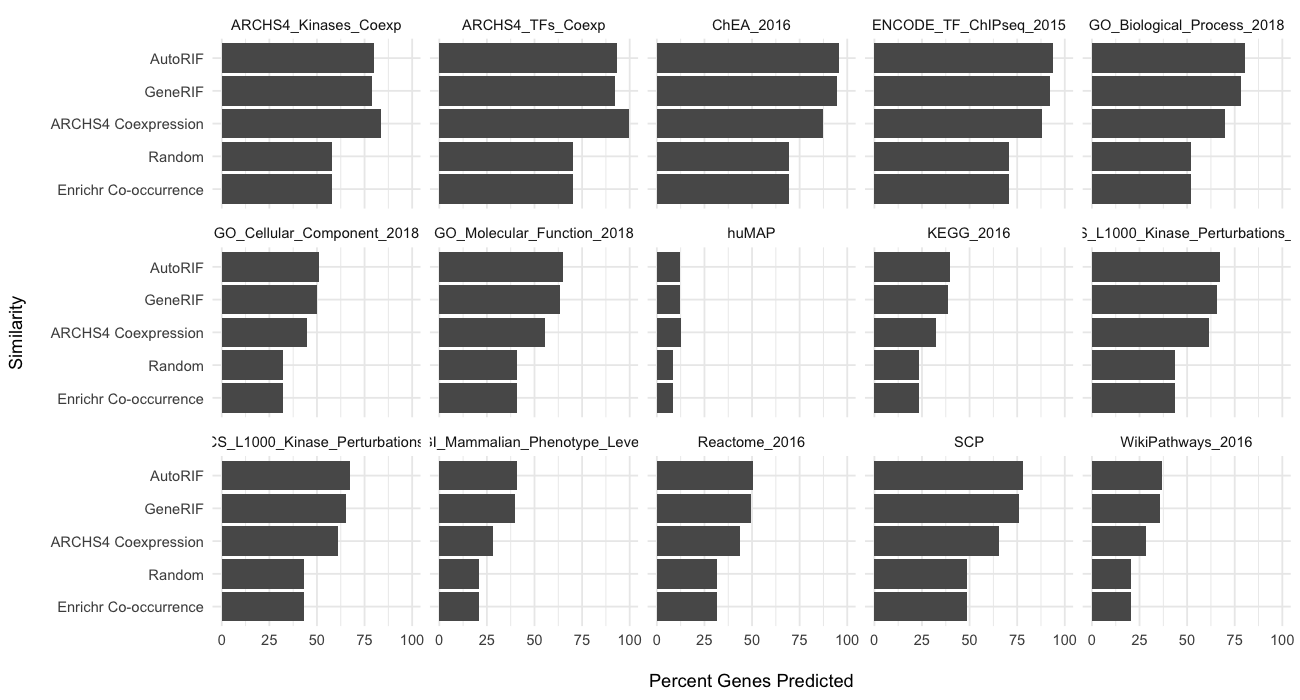

In [122]:
%%R -i plot_dataframe -h 700 -w 1300 -r 120
ggplot(plot_dataframe, aes(x=reorder(Similarity, fraction_predicted), y=fraction_predicted*100)) +
geom_bar(stat='identity') +
# geom_abline(intercept=0, slope=1, alpha=0.5, color='grey') +
facet_wrap(~library, ncol=5) +
coord_flip() + 
# scale_x_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks) +
# scale_y_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks) +
xlab('Similarity\n') +
ylab('\nPercent Genes Predicted') +
theme_minimal()

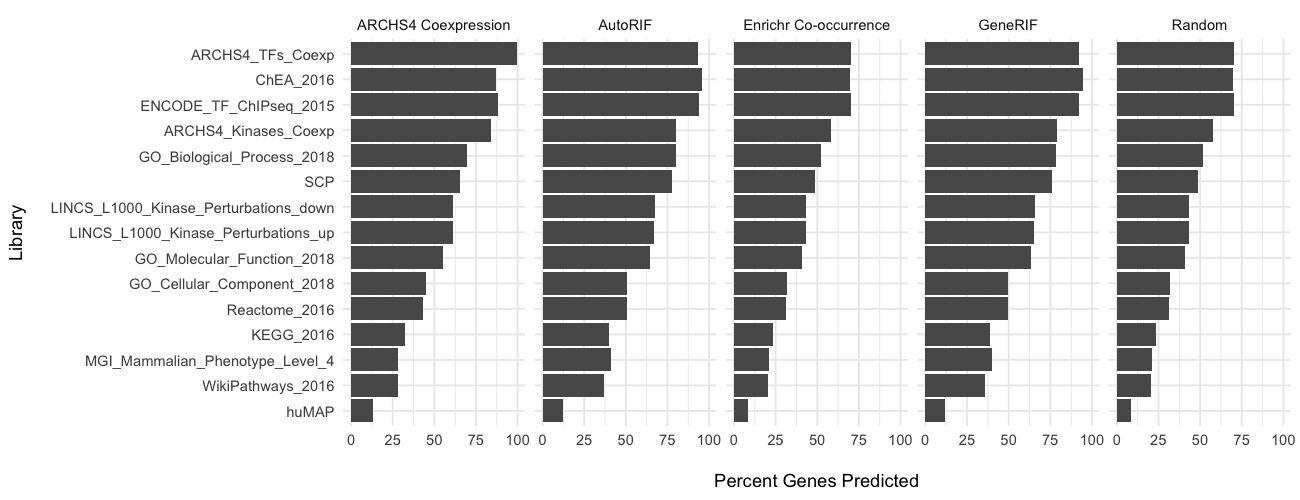

In [126]:
%%R -i plot_dataframe -h 500 -w 1300 -r 120
ggplot(plot_dataframe, aes(x=reorder(library, fraction_predicted), y=fraction_predicted*100)) +
geom_bar(stat='identity') +
# geom_abline(intercept=0, slope=1, alpha=0.5, color='grey') +
facet_wrap(~Similarity, ncol=5) +
coord_flip() + 
# scale_x_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks) +
# scale_y_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks) +
xlab('Library\n') +
ylab('\nPercent Genes Predicted') +
theme_minimal()